In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from Vis import plot_loss, plot_roc
from Preprocessing import Preprocessing
from Preprocessing import Cols
import numpy as np
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from pandas import DataFrame
from pandas import Series
import pandas as pd
from keras.layers import Dropout
# pandas.set_option('max_columns',10)

Using TensorFlow backend.


In [3]:
pre = Preprocessing()
X, y = pre.load_data(time_gap=300)

prepared dataset contains: per_stud_dataset + per_action_dataset_summ


In [4]:
per_action_dataset = pre.per_action_dataset
per_action_dataset.index = per_action_dataset.ITEST_id
per_action_dataset = per_action_dataset.drop("ITEST_id", axis=1)
per_action_dataset = per_action_dataset.drop(['assistmentId', 'problemId', 'assignmentId', 'actionId'], axis=1)

In [5]:
# show the seq of a sample student (id =9)
#per_action_dataset[per_action_dataset.index.get_level_values(0) ==9].head()

,frWorkingInSchool,sumRight,endsWithScaffolding,scaffold,stlHintUsed,hintCount,frIsHelpRequest,totalFrPastWrongCount,totalFrSkillOpportunitiesByScaffolding,RES_CONCENTRATING,...,bottomHint,frPast8HelpRequest,endsWithAutoScaffolding,responseIsFillIn,endTime,frTotalSkillOpportunitiesScaffolding,frIsHelpRequestScaffolding,totalFrSkillOpportunities,manywrong,frPast5HelpRequest
ITEST_id,,,,,,,,,,,,,,,,,,,,,
9,1,0,0,0,0,1,1,0,0.0,0.320317,...,0,0,0,0,1131985200,0,0,0,0,0
9,1,1,1,1,0,0,1,0,0.0,0.225154,...,0,1,0,0,1131985296,0,1,1,0,1
9,1,2,1,1,0,0,1,0,2.0,0.665929,...,0,2,0,0,1131985347,1,1,2,0,2
9,1,3,1,1,0,0,1,0,1.5,0.780156,...,0,3,0,0,1131985374,2,1,3,0,3
9,1,3,0,0,0,0,0,0,0.0,0.195349,...,0,0,0,0,1131985476,0,0,0,0,0


In [6]:
#truncating seq of each student and only considering his last 500 actions based on startTime feature
truncated_input = per_action_dataset.sort_values("startTime",ascending=False).groupby('ITEST_id').head(500)

In [7]:
# scaling dataset
scaler = RobustScaler()
X_scaled = scaler.fit_transform(truncated_input)
X_scaled = DataFrame(X_scaled, index=truncated_input.index, columns=truncated_input.columns)
#X_scaled[X_scaled.index.get_level_values(0) ==9].head()

,frWorkingInSchool,sumRight,endsWithScaffolding,scaffold,stlHintUsed,hintCount,frIsHelpRequest,totalFrPastWrongCount,totalFrSkillOpportunitiesByScaffolding,RES_CONCENTRATING,...,bottomHint,frPast8HelpRequest,endsWithAutoScaffolding,responseIsFillIn,endTime,frTotalSkillOpportunitiesScaffolding,frIsHelpRequestScaffolding,totalFrSkillOpportunities,manywrong,frPast5HelpRequest
ITEST_id,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.511628,-1.0,0.0,0.0,0.0,0.0,0.5,-0.68,0.280209,...,0.0,0.0,0.0,0.0,0.799939,-0.4,-1.0,0.000000,-1.0,0.000000
9,0.0,0.505814,-1.0,0.0,0.0,0.0,0.0,0.0,-0.68,0.229497,...,0.0,0.0,0.0,0.0,0.799938,-0.4,-1.0,-0.222222,-1.0,0.000000
9,0.0,0.500000,-1.0,0.0,0.0,0.0,0.0,0.0,-0.68,-0.769739,...,0.0,-0.5,0.0,0.0,0.799935,-0.4,-1.0,-0.444444,-1.0,-0.666667
9,0.0,0.500000,-1.0,0.0,0.0,0.0,0.0,0.0,-0.68,0.029696,...,0.0,-0.5,0.0,0.0,0.799937,-0.4,-1.0,-0.444444,-1.0,-0.666667
9,0.0,0.494186,-1.0,0.0,0.0,0.0,0.0,-0.5,-0.68,-0.769739,...,0.0,-0.5,0.0,0.0,0.799935,-0.4,-1.0,-0.555556,-1.0,-0.666667


In [8]:
# defining sequence length (or number of time-steps) for each student and batch-size
max_length_seq = 500

In [17]:
batch_size=10

In [9]:
# padding sequences to have a same length
X_padded = []
for stud_id, stud_seq in X_scaled.groupby(by='ITEST_id'):
    X_padded.append(stud_seq)
X_padded = sequence.pad_sequences(X_padded, max_length_seq, dtype='float64')

In [10]:
pd.set_option('max_columns',90)
# getting a sense about padded dataset
new_seq_ix = pd.Index(list(range(0,max_length_seq))* X_padded.shape[0], name="seq_ix")
ITEST_ix = pd.Index(np.repeat(sorted(X_scaled.index.get_level_values(0).unique()), max_length_seq), name='ITEST_id')
paddedData = DataFrame(X_padded.reshape(X_padded.shape[0]*X_padded.shape[1], -1), index=[ITEST_ix, new_seq_ix], columns=X_scaled.columns)
#paddedData[paddedData.index.get_level_values(0) == 27].head()

frWorkingInSchool  sumRight  endsWithScaffolding  scaffold  \
ITEST_id seq_ix                                                               
27       0                     0.0       0.0                  0.0       0.0   
         1                     0.0       0.0                  0.0       0.0   
         2                     0.0       0.0                  0.0       0.0   
         3                     0.0       0.0                  0.0       0.0   
         4                     0.0       0.0                  0.0       0.0   

                 stlHintUsed  hintCount  frIsHelpRequest  \
ITEST_id seq_ix                                            
27       0               0.0        0.0              0.0   
         1               0.0        0.0              0.0   
         2               0.0        0.0              0.0   
         3               0.0        0.0              0.0   
         4               0.0        0.0              0.0   

                 totalFrPastWrongCount  \
ITEST_id seq_ix                          
27       0                         0.0   
         1                         0.0   
         2                         0.0   
         3                         0.0   
         4                         0.0   

                 totalFrSkillOpportunitiesByScaffolding  RES_CONCENTRATING  \
ITEST_id seq_ix                                                              
27       0                                          0.0                0.0   
         1                                          0.0                0.0   
         2                                          0.0                0.0   
         3                                          0.0                0.0   
         4                                          0.0                0.0   

                 timeTaken  correct  hintTotal  frTimeTakenOnScaffolding  \
ITEST_id seq_ix                                                            
27       0             0.0      0.0        0.0                       0.0   
         1             0.0      0.0        0.0                       0.0   
         2             0.0      0.0        0.0                       0.0   
         3             0.0      0.0        0.0                       0.0   
         4             0.0      0.0        0.0                       0.0   

                 attemptCount  consecutiveErrorsInRow  RES_GAMING  \
ITEST_id seq_ix                                                     
27       0                0.0                     0.0         0.0   
         1                0.0                     0.0         0.0   
         2                0.0                     0.0         0.0   
         3                0.0                     0.0         0.0   
         4                0.0                     0.0         0.0   

                 totalTimeByPercentCorrectForskill  original  \
ITEST_id seq_ix                                                
27       0                                     0.0       0.0   
         1                                     0.0       0.0   
         2                                     0.0       0.0   
         3                                     0.0       0.0   
         4                                     0.0       0.0   

                 totalFrPercentPastWrong  sumTimePerSkill  RES_BORED  \
ITEST_id seq_ix                                                        
27       0                           0.0              0.0        0.0   
         1                           0.0              0.0        0.0   
         2                           0.0              0.0        0.0   
         3                           0.0              0.0        0.0   
         4                           0.0              0.0        0.0   

                 frPast5WrongCount  past8BottomOut  frPast8WrongCount  \
ITEST_id seq_ix                                                         
27       0                     0.0             0.0                0.0   
         1

In [11]:
# creating label dataset with index as ITEST_id values
label_dataset = pre.label_dataset[['ITEST_id', 'isSTEM']]
label_dataset.index = label_dataset.ITEST_id
label_dataset = label_dataset.drop("ITEST_id", axis = 1)
#label_dataset

,isSTEM
ITEST_id,
9,1
27,0
33,0
35,0
37,0
41,0
77,0
87,0
114,0


In [12]:
# join label with dataset to make sure we have a consistent dataset
# (of course before the training the label column will be droped from data)
X_with_label = paddedData.join(label_dataset)
#print(X_with_label.shape)
#X_with_label

(233500, 48)


frWorkingInSchool  sumRight  endsWithScaffolding  scaffold  \
ITEST_id seq_ix                                                               
9        0                     0.0  0.511628                 -1.0       0.0   
         1                     0.0  0.505814                 -1.0       0.0   
         2                     0.0  0.500000                 -1.0       0.0   
         3                     0.0  0.500000                 -1.0       0.0   
         4                     0.0  0.494186                 -1.0       0.0   
         5                     0.0  0.494186                  0.0       1.0   
         6                     0.0  0.488372                  0.0       1.0   
         7                     0.0  0.482558                  0.0       1.0   
         8                     0.0  0.476744                  0.0       0.0   
         9                     0.0  0.476744                 -1.0       0.0   
         10                    0.0  0.476744                  0.0       1.0   
         11                    0.0  0.470930                  0.0       1.0   
         12                    0.0  0.465116                  0.0       1.0   
         13                    0.0  0.459302                  0.0       0.0   
         14                    0.0  0.459302                  0.0       0.0   
         15                    0.0  0.459302                  0.0       0.0   
         16                    0.0  0.459302                 -1.0       0.0   
         17                    0.0  0.459302                 -1.0       0.0   
         18                    0.0  0.453488                 -1.0       0.0   
         19                    0.0  0.453488                  0.0       1.0   
         20                    0.0  0.447674                  0.0       1.0   
         21                    0.0  0.441860                  0.0       1.0   
         22                    0.0  0.436047                  0.0       0.0   
         23                    0.0  0.436047                  0.0       1.0   
         24                    0.0  0.436047                  0.0       1.0   
         25                    0.0  0.436047                 -1.0       0.0   
         26                    0.0  0.436047                  0.0       1.0   
         27                    0.0  0.430233                  0.0       1.0   
         28                    0.0  0.430233                  0.0       1.0   
         29                    0.0  0.430233                  0.0       1.0   
...                            ...       ...                  ...       ...   
7782     470                   0.0 -0.720930                 -1.0       0.0   
         471                   0.0 -0.720930                  0.0       0.0   
         472                   0.0 -0.720930                  0.0       0.0   
         473                   0.0 -0.720930                  0.0       1.0   
         474                   0.0 -0.720930                 -1.0       0.0   
         475                   0.0 -0.720930                 -1.0       0.0   
         476                   0.0 -0.726744                 -1.0       0.0   
         477                   0.0 -0.726744                 -1.0       0.0   
         478                   0.0 -0.726744                  0.0       1.0   
         479                   0.0 -0.732558                  0.0       1.0   
         480                   0.0 -0.732558                  0.0       1.0   
         481                   0.0 -0.732558                  0.0       1.0   
         482                   0.0 -0.738372                 -1.0       0.0   
         483                   0.0 -0.744186                 -1.0       0.0   
         484                   0.0 -0.744186                  0.0       1.0   
         485                   0.0 -0.744186                  0.0       1.0   
         486                   0.0 -0.750000                 -1.0       0.0   
         487                   0.0 -0.750000                  0.0  

In [13]:
y_prepared = X_with_label.groupby("ITEST_id").isSTEM.first().values
X_prepared = X_with_label.drop("isSTEM", axis=1)
X_prepared = X_prepared.values.reshape((-1, max_length_seq, X_prepared.shape[1]))
#print(X_prepared.shape)
#X_prepared

(467, 500, 47)


array([[[ 0.        ,  0.51162791, -1.        , ...,  0.        ,
         -1.        ,  0.        ],
        [ 0.        ,  0.50581395, -1.        , ..., -0.22222222,
         -1.        ,  0.        ],
        [ 0.        ,  0.5       , -1.        , ..., -0.44444444,
         -1.        , -0.66666667],
        ..., 
        [ 0.        , -0.75581395, -1.        , ..., -0.44444444,
         -1.        , -0.66666667],
        [ 0.        , -0.75581395, -1.        , ..., -0.44444444,
         -1.        , -0.66666667],
        [ 0.        , -0.75581395, -1.        , ..., -0.55555556,
         -1.        , -0.66666667]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        , -0.76744186,  0.        , ...,

## Model

In [14]:
def create_LSTM_model(max_length_seq, feature_size):
    # create the LSTM network
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(max_length_seq, feature_size)))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
# splitting train/test data 
X_train, X_test, y_train,y_test = train_test_split(X_prepared,y_prepared, train_size=.99)

In [18]:
# Create model
model = create_LSTM_model(max_length_seq, X_train.shape[2])
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_split=0.33)

Train on 309 samples, validate on 153 samples
Epoch 1/5
309/309 [==============================] - 51s - loss: 0.6163 - acc: 0.7055 - val_loss: 0.5401 - val_acc: 0.7908
Epoch 2/5
309/309 [==============================] - 48s - loss: 0.5683 - acc: 0.7249 - val_loss: 0.5284 - val_acc: 0.7908
Epoch 3/5
309/309 [==============================] - 49s - loss: 0.5606 - acc: 0.7217 - val_loss: 0.5555 - val_acc: 0.7582
Epoch 4/5
309/309 [==============================] - 49s - loss: 0.5276 - acc: 0.7411 - val_loss: 0.5592 - val_acc: 0.7712
Epoch 5/5
309/309 [==============================] - 49s - loss: 0.4901 - acc: 0.7864 - val_loss: 0.5828 - val_acc: 0.7516


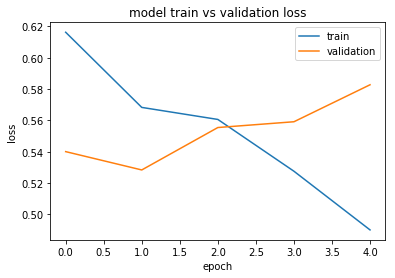

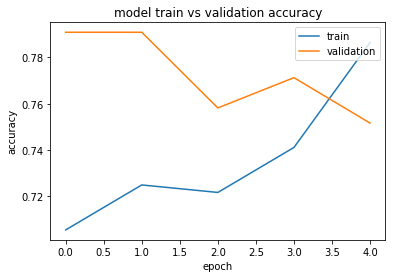

In [28]:
plot_loss(history)
plot_accuracy(history)

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from Vis import plot_accuracy
# do prediction
y_pred = model.predict(X_test, batch_size=batch_size)

# calculating scores
roc_score = roc_auc_score(y_test, y_pred)
mse_score = mean_squared_error(y_test, y_pred)

# printing and plotting model and score information
plot_loss(history)
plot_roc(y_test, y_pred)
plot_accuracy(history)

print(model.summary())
print("Test ROC Score: %f" % roc_score)
print("Test RMSE Score: %f" % sqrt(mse_score))
print("Final Competition Score: %f" % (1 - sqrt(mse_score) + roc_score))

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

## EDA

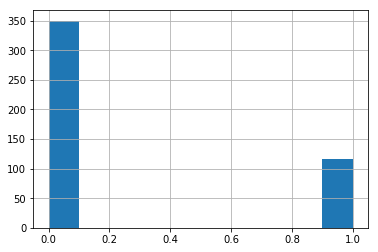

In [25]:
# see the dist. of labels: unbalanced labels!
X_with_label.groupby('ITEST_id').isSTEM.mean().hist()

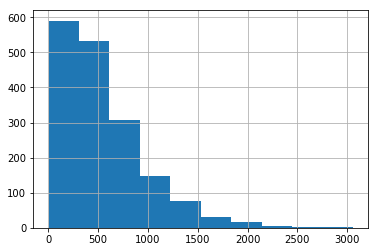

In [3]:
# number of actions for each student before summarization
pre.raw_dataset.groupby("ITEST_id").size().hist()